# 设置环境

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# 准备数据集
导入就绪后，我们可以继续准备将要使用的数据。但在那之前，我们将定义超参数，我们将使用的实验。在这里，epoch的数量定义了我们将循环整个训练数据集的次数，而learning_rate和momentum是我们稍后将使用的优化器的超参数。

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([7, 6, 7, 5, 6, 7, 8, 1, 1, 2, 4, 1, 0, 8, 4, 4, 4, 9, 8, 1, 3, 3, 8, 6,
        2, 7, 5, 1, 6, 5, 6, 2, 9, 2, 8, 4, 9, 4, 8, 6, 7, 7, 9, 8, 4, 9, 5, 3,
        1, 0, 9, 1, 7, 3, 7, 0, 9, 2, 5, 1, 8, 9, 3, 7, 8, 4, 1, 9, 0, 3, 1, 2,
        3, 6, 2, 9, 9, 0, 3, 8, 3, 0, 8, 8, 5, 3, 8, 2, 8, 5, 5, 7, 1, 5, 5, 1,
        0, 9, 7, 5, 2, 0, 7, 6, 1, 2, 2, 7, 5, 4, 7, 3, 0, 6, 7, 5, 1, 7, 6, 7,
        2, 1, 9, 1, 9, 2, 7, 6, 8, 8, 8, 4, 6, 0, 0, 2, 3, 0, 1, 7, 8, 7, 4, 1,
        3, 8, 3, 5, 5, 9, 6, 0, 5, 3, 3, 9, 4, 0, 1, 9, 9, 1, 5, 6, 2, 0, 4, 7,
        3, 5, 8, 8, 2, 5, 9, 5, 0, 7, 8, 9, 3, 8, 5, 3, 2, 4, 4, 6, 3, 0, 8, 2,
        7, 0, 5, 2, 0, 6, 2, 6, 3, 6, 6, 7, 9, 3, 4, 1, 6, 2, 8, 4, 7, 7, 2, 7,
        4, 2, 4, 9, 7, 7, 5, 9, 1, 3, 0, 4, 4, 8, 9, 6, 6, 5, 3, 3, 2, 3, 9, 1,
        1, 4, 4, 8, 1, 5, 1, 8, 8, 0, 7, 5, 8, 4, 0, 0, 0, 6, 3, 0, 9, 0, 6, 6,
        9, 8, 1, 2, 3, 7, 6, 1, 5, 9, 3, 9, 3, 2, 5, 9, 9, 5, 4, 9, 3, 9, 6, 0,
        3, 3, 8, 3, 1, 4, 1, 4, 7, 3, 1,

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

<Figure size 640x480 with 6 Axes>

# 构建网络
现在让我们开始建立我们的网络。我们将使用两个2d卷积层，然后是两个全连接(或线性)层。作为激活函数，我们将选择整流线性单元(简称ReLUs)，作为正则化的手段，我们将使用两个dropout层。在PyTorch中，构建网络的一个好方法是为我们希望构建的网络创建一个新类。让我们在这里导入一些子模块，以获得更具可读性的代码。

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

初始化网络和优化器

In [7]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# 模型训练
首先，我们需要使用optimizer.zero_grad()手动将梯度设置为零，因为PyTorch在默认情况下会累积梯度。然后，我们生成网络的输出(前向传递)，并计算输出与真值标签之间的负对数概率损失。现在，我们收集一组新的梯度，并使用optimizer.step()将其传播回每个网络参数。有关PyTorch自动渐变系统内部工作方式的详细信息，请参阅autograd的官方文档(强烈推荐)。

我们还将使用一些打印输出来跟踪进度。为了在以后创建一个良好的培训曲线，我们还创建了两个列表来节省培训和测试损失。在x轴上，我们希望显示网络在培训期间看到的培训示例的数量。

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')
          
# train(1)

# 模型测试
现在进入测试循环。在这里，我们总结了测试损失，并跟踪正确分类的数字来计算网络的精度。

In [10]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()

/home/pjw/anaconda3/envs/pjw/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/pjw/anaconda3/envs/pjw/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)



# 评估模型的性能

/home/pjw/anaconda3/envs/pjw/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153432
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096480
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974481
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944860
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839772
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.769052
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.694407
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.688283
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.509173
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.389769
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.286089
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.329786
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.278228
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.244968
Train Epoch: 1 [12800/60000 (

/home/pjw/anaconda3/envs/pjw/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1975, Accuracy: 9432/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.546566
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.305779
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.385171
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.295484
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.474659
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.677941
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.539200
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.451135
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.404221
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.486087
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.515891
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.405879
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.304106
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.360732
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.394584
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.410758
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.396205
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.591816
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.559890
Train Epoch: 2 [12160

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.317007
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.253613
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.244356
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.267757
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.534147
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.346594
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.395763
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.208188
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.162138
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.488596
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.301980
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.266382
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.226191
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.227062
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.251021
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.422545
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.427200
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.281048
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.252998
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.301540


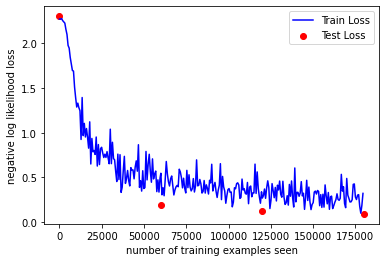

In [11]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()